## Import Library and Tool

In [1]:
### Inport Library
import pandas as pd
import numpy as np
from numpy import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import pywt

from tqdm import tqdm
import re

import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
import tensorflow_addons as tfa

import keras
import keras.backend as K
from keras.utils.vis_utils import plot_model

from keras import Model, Sequential
from keras.layers import Conv1D, SeparableConv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.layers import GRU, LSTM, TimeDistributed
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import L1L2, L2

### Tools
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Load Data

In [2]:
DATA_PATH = './data/merge.csv'

df = pd.read_csv(DATA_PATH, low_memory=False)

print(f'total data: {len(df)}')
df.sample(10)

total data: 1265657


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
797670,NC,GDXB,HH,38.807968,-122.795303,939.0,500.0,manual,0.68,0.93000,...,None,None,0.03783,4.21,61.20,[42.29999924 41.59999847 34. ],[[1316.]],2017-11-21 12:36:51.940000,earthquake_local,GDXB.NC_20171121123650_EV
569537,BK,BRIB,HH,37.918860,-122.151790,219.7,900.0,manual,0.69,4.66000,...,NC,None,0.19820,21.97,174.10,[18.70000076 17. 17.79999924],[[2054.]],2007-08-26 19:17:08.680000,earthquake_local,BRIB.BK_20070826191707_EV
369232,PB,B082,HH,33.598182,-116.596005,1374.8,499.0,autopicker,0.93,2.93000,...,None,None,0.10180,11.32,282.40,[22.5 21.60000038 22.20000076],[[1147.]],2017-11-13 11:35:40.510000,earthquake_local,B082.PB_20171113113539_EV
539877,BK,BDM,HH,37.953970,-121.865540,219.8,500.0,manual,0.50,19.85000,...,None,None,1.13000,125.30,138.70,[22.10000038 27.5 28.20000076],[[5900.]],2012-07-09 00:01:33.840000,earthquake_local,BDM.BK_20120709000132_EV
640563,AZ,CRY,HH,33.565400,-116.737300,1128.0,580.0,autopicker,0.79,12.58000,...,CI,None,0.67140,74.66,0.60,[15.60000038 20.5 11.89999962],[[2783.]],2011-11-17 07:34:47.490000,earthquake_local,CRY.AZ_20111117073446_EV
671983,AK,DHY,BH,63.075300,-147.375900,1611.0,800.0,manual,0.83,10.33600,...,None,None,0.51900,57.83,322.27,[29.39999962 33.79999924 37.29999924],[[2890.]],2012-07-04 07:21:53.356000,earthquake_local,DHY.AK_20120704072152_EV
120741,BK,JRSC,HN,37.403800,-122.237600,103.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-11 10:32:00,noise,JRSC.BK_201501111032_NO
865049,GS,KAN05,HH,37.108650,-97.872280,348.0,800.0,manual,0.61,5.65000,...,ISMP,None,0.27620,30.70,100.30,[18.10000038 16.70000076 11.60000038],[[3136.]],2015-09-01 15:21:47.640000,earthquake_local,KAN05.GS_20150901152146_EV
1262051,SN,YFT,EH,37.076200,-115.974400,1354.0,500.0,manual,0.00,9.24429,...,NN,None,0.50700,56.47,279.59,[63.59999847 67. 61.70000076],[[2210.]],2014-01-12 22:04:38.559290,earthquake_local,YFT.SN_20140112220437_EV
756582,NC,GDXB,HH,38.807968,-122.795303,939.0,598.0,autopicker,0.92,1.09000,...,NC,None,0.04234,4.74,301.00,[17.79999924 16.10000038 17. ],[[1423.]],2013-01-16 05:46:20.740000,earthquake_local,GDXB.NC_20130116054619_EV


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265657 entries, 0 to 1265656
Data columns (total 35 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   network_code                      1265613 non-null  object 
 1   receiver_code                     1265657 non-null  object 
 2   receiver_type                     1265657 non-null  object 
 3   receiver_latitude                 1265657 non-null  float64
 4   receiver_longitude                1265657 non-null  float64
 5   receiver_elevation_m              1265657 non-null  float64
 6   p_arrival_sample                  1030231 non-null  float64
 7   p_status                          1030231 non-null  object 
 8   p_weight                          1030057 non-null  float64
 9   p_travel_sec                      1030231 non-null  float64
 10  s_arrival_sample                  1030231 non-null  float64
 11  s_status                          103

In [4]:
df_extract_column = df[['receiver_latitude', 'receiver_longitude',
                        'p_arrival_sample', 'p_weight', 'p_travel_sec',
                        'source_origin_time', 'source_origin_uncertainty_sec',
                        'source_latitude', 'source_longitude', 'source_distance_deg', 'source_distance_km',
                        'back_azimuth_deg',
                        'snr_db', 'trace_category', 'trace_name']]
print(f'shape: {df_extract_column.shape}')
df_extract_column.head()

shape: (1265657, 15)


,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name
0,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201510210555_NO
1,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511061450_NO
2,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511070220_NO
3,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201511140515_NO
4,32.8889,-117.1051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,109C.TA_201512251850_NO


In [5]:
df_earthquake = df_extract_column[df_extract_column['trace_category'] == 'earthquake_local'].reset_index(drop=True)
print(f'shape: {df_earthquake.shape}')
df_earthquake.head()

shape: (1030231, 15)


,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name
0,32.8889,-117.1051,700.0,0.5,17.080000,2006-07-23 15:58:50.88,0.47,33.7496,-117.4938,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],earthquake_local,109C.TA_20060723155859_EV
1,32.8889,-117.1051,600.0,0.5,16.879999,2006-11-03 15:56:42.73,0.24,32.7077,-116.0446,0.91,101.34,281.7,[65. 65.5 61.40000153],earthquake_local,109C.TA_20061103155652_EV
2,32.8889,-117.1051,500.0,0.5,17.260000,2006-11-03 16:12:12.44,0.27,32.7253,-116.0348,0.92,101.87,280.5,[37.20000076 42. 38.59999847],earthquake_local,109C.TA_20061103161223_EV
3,32.8889,-117.1051,900.0,0.5,17.280001,2006-11-14 13:32:14.26,0.25,32.7063,-116.0241,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],earthquake_local,109C.TA_20061114133221_EV
4,32.8889,-117.1051,700.0,0.5,18.139999,2006-11-27 10:46:29.92,0.67,31.9679,-117.1944,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],earthquake_local,109C.TA_20061127104640_EV


In [6]:
tqdm.pandas()

def snr_mean(data):
    text = re.sub(r'[\[\]]', '', data)
    mean = np.mean([float(x) for x in text.split()])
    return mean

df_earthquake['snr_db_mean'] = df_earthquake['snr_db'].progress_map(snr_mean)
df_earthquake_selected_distance_snr_P = df_earthquake[(df_earthquake['source_distance_km'] < 110) &
                                                        (df_earthquake['snr_db_mean'] > 25) & 
                                                        (df_earthquake['p_arrival_sample'] >= 50)]
print(f'shape: {df_earthquake_selected_distance_snr_P.shape}')
df_earthquake_selected_distance_snr_P.head()

100%|█████████████████████████████████████████████████████████████████████| 1030231/1030231 [00:53<00:00, 19416.28it/s]


shape: (457605, 16)


,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name,snr_db_mean
0,32.8889,-117.1051,700.0,0.5,17.080000,2006-07-23 15:58:50.88,0.47,33.7496,-117.4938,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],earthquake_local,109C.TA_20060723155859_EV,53.200001
1,32.8889,-117.1051,600.0,0.5,16.879999,2006-11-03 15:56:42.73,0.24,32.7077,-116.0446,0.91,101.34,281.7,[65. 65.5 61.40000153],earthquake_local,109C.TA_20061103155652_EV,63.966667
2,32.8889,-117.1051,500.0,0.5,17.260000,2006-11-03 16:12:12.44,0.27,32.7253,-116.0348,0.92,101.87,280.5,[37.20000076 42. 38.59999847],earthquake_local,109C.TA_20061103161223_EV,39.266666
3,32.8889,-117.1051,900.0,0.5,17.280001,2006-11-14 13:32:14.26,0.25,32.7063,-116.0241,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],earthquake_local,109C.TA_20061114133221_EV,51.500000
4,32.8889,-117.1051,700.0,0.5,18.139999,2006-11-27 10:46:29.92,0.67,31.9679,-117.1944,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],earthquake_local,109C.TA_20061127104640_EV,56.066667


In [7]:
TOTAL_SAMPLE = 150000
# TOTAL_SAMPLE = 1000

# df_final = pd.concat([df_earthquake.sample(int(TOTAL_SAMPLE * 0.8)),
#                     df_noise.sample(int(TOTAL_SAMPLE * 0.2))]).reset_index(drop=True)
df_final = df_earthquake_selected_distance_snr_P.sample(TOTAL_SAMPLE).reset_index(drop=True)
print(f'shape: {df_final.shape}')
df_final.head()

shape: (150000, 16)


,receiver_latitude,receiver_longitude,p_arrival_sample,p_weight,p_travel_sec,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,trace_category,trace_name,snr_db_mean
0,35.935700,-117.601700,399.0,0.94,2.29,2015-09-20 14:15:21.440000,None,36.03267,-117.56967,0.1002,11.14,15.0,[38.20000076 40.79999924 45.09999847],earthquake_local,B918.PB_20150920141518_EV,41.366666
1,18.142069,-65.848850,800.0,0.47,17.41,2018-06-18 23:44:02.890000,None,18.49830,-66.71100,0.9000,99.90,293.0,[27.79999924 27.29999924 24.70000076],earthquake_local,HUMP.PR_20180618234412_EV,26.600000
2,46.169000,-122.333667,800.0,0.68,12.87,2012-09-05 07:32:41.880000,NaN,46.83630,-121.93370,0.7225,80.28,22.6,[30.70000076 32.90000153 30.39999962],earthquake_local,B203.PB_20120905073245_EV,31.333334
3,35.267420,-117.845810,600.0,0.93,2.35,2017-11-11 18:45:01.650000,None,35.35533,-117.91100,0.1026,11.41,328.8,[46.90000153 50.40000153 43.20000076],earthquake_local,DTP.CI_20171111184457_EV,46.833335
4,36.851500,-97.859590,550.0,0.93,3.80,2015-03-24 19:48:28.80,0.8,36.76060,-98.01540,0.1500,17.18,54.0,[63.40000153 66.69999695 59.5 ],earthquake_local,GC02.OK_20150324194826_EV,63.199999


## Data Preprocessing

In [8]:
# Fungsi untuk mengambil data np waveform
# berdasarkan data pada nama riwayat waveform tertentu yang diperlukan

def get_waveform(trace_name):
    '''
    Kolom 1: East-West Channel
    Kolom 2: North-South Channel
    Kolom 3: Z (Vertical) Channel
    '''
    filename = "Data/merge.hdf5"
    with h5py.File(filename, "r") as file:
        data = file.get('data/'+trace_name)
        data = np.array(data)
    return data

# A function for plotting each of 3 waveform channel
# With desired minimal and maximal timestamp
def plot_channel_waveform(waveform_data, waveform_min=0, waveform_max=6000, total_channel=3, p_arrival=None):
    fig, ax = plt.subplots(total_channel, 1, figsize=[15, total_channel*3], sharey=True)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    
#     print(waveform_min)
#     print(waveform_max)

    channel_title = ['East-West Channel', 'North-South Channel', 'Z (Vertical) Channel']
    for col_number in range(total_channel):
        if total_channel != 1:
            ax[col_number].plot(np.arange(waveform_min, waveform_max, 1),
                                waveform_data[waveform_min:waveform_max, col_number],
                                color='black')
            if p_arrival != None:
                ax[col_number].axvline(p_arrival, 0.1, 0.9, label=f'P Arrival: {p_arrival}')
            ax[col_number].set_title(channel_title[col_number])
            ax[col_number].set_xlabel('Timestamp (in ms)')
            ax[col_number].set_ylabel('Waveform Data') 
            ax[col_number].legend()
        elif total_channel == 1:
            ax.plot(np.arange(waveform_min, waveform_max, 1),
                                waveform_data[waveform_min:waveform_max, col_number],
                                color='black')
            if p_arrival != None:
                ax.axvline(p_arrival, 0.2, 0.8, label=f'P Arrival: {p_arrival}')
            ax.set_title(channel_title[col_number])
            ax.set_xlabel('Timestamp (in ms)')
            ax.set_ylabel('Waveform Data')
            ax.legend()

    plt.show()
    
# A function for reduce noise that waveform data signal have,
# Using Wavelet Denoise Method.
def wavelet_denoising(data, thresholding_method='BayesShrink', wavelet_name='db1'):
    def BayesShrink():
        im_bayes = denoise_wavelet(data, wavelet=wavelet_name,
                                   channel_axis=-1, convert2ycbcr=True,
                                   method='BayesShrink', mode='soft', wavelet_levels=4,
                                   rescale_sigma=True)
        return im_bayes
    
    def VisuShrink():
        sigma_est = estimate_sigma(data, channel_axis=-1, average_sigmas=True)
        im_visu = denoise_wavelet(data, wavelet=wavelet_name,
                                  channel_axis=-1, convert2ycbcr=True,
                                  method='VisuShrink', mode='soft', wavelet_levels=4,
                                  sigma=sigma_est, rescale_sigma=True)
        
        return im_visu
    
    if thresholding_method == 'BayesShrink':
        return BayesShrink()
    elif thresholding_method == 'VisuShrink':
        return VisuShrink()

### Sample Of One Trace Data Waveform

In [9]:
# np.random.seed(2022)

index = 0 #random.randint(0, 1000)
waveform_data_sample = df_final.iloc[index, :]
waveform_sample = get_waveform(waveform_data_sample['trace_name'])

# The shape describe of total timestamp for each waveform data
# at milisecond unit in 1 minutes duration, that contain each 3 
# channel data.
print(type(waveform_sample))
print(f'waveform shape data: {waveform_sample.shape}')
print(f'waveform numeric data:\n{waveform_sample}')

<class 'numpy.ndarray'>
waveform shape data: (6000, 3)
waveform numeric data:
[[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 1.9453622e-04 -1.5099623e-04  3.2880489e-04]
 [ 1.6383952e-04 -1.5371018e-04  1.3358479e-03]
 ...
 [-1.4976524e-03 -4.2797317e-04 -1.9205814e-04]
 [-2.1197503e-04 -3.4958241e-04  7.1303592e-05]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]]


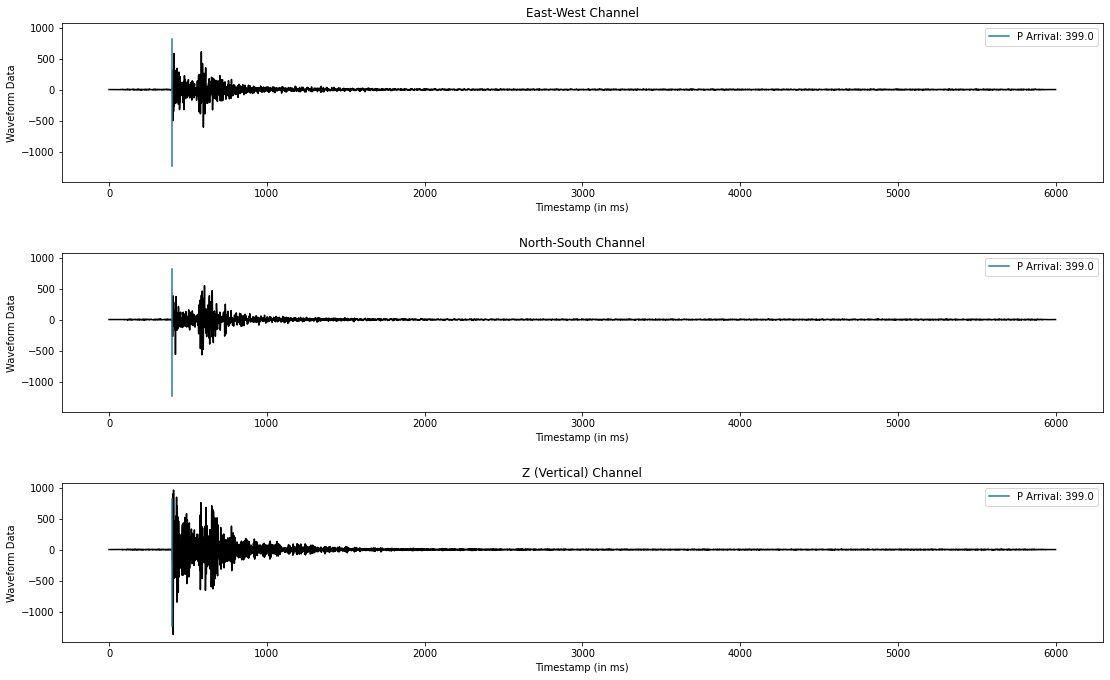

In [10]:
plot_channel_waveform(waveform_sample, p_arrival=waveform_data_sample['p_arrival_sample'])

### Waveform From 1.5 Second At P-Arrival

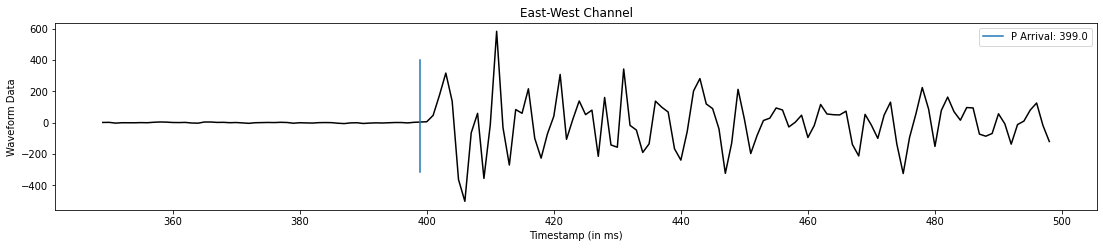

In [11]:
# take a ground motion timestamp from
# 0.5 second before and 1 second after P-Arrival
plot_channel_waveform(waveform_sample,
                      waveform_min=int(waveform_data_sample['p_arrival_sample'] - 50),
                      waveform_max=int(waveform_data_sample['p_arrival_sample'] + 100),
                      total_channel=1,
                      p_arrival=waveform_data_sample['p_arrival_sample'])

### Create Dataset For Training Model

In [12]:
def create_dataset(data_init, train_split=0.7, val_split=0.15):
    def create_feature(data, p_arrival):
        feature_waveform = []
        feature_matrix = []

        for index in tqdm(range(len(data))):
            # Get Waveform Window Data
            wf = get_waveform(data[index])
            wf_denoise = wavelet_denoising(wf, wavelet_name='db7')
            wf_p_arrival = wf_denoise[int(p_arrival[index] - 50):int(p_arrival[index] + 100)]
            feature_waveform.append(wf_p_arrival)

            # Get Waveform Matrix Data
            wf_cov = np.cov(wf_p_arrival, rowvar=False)
            wf_eigvals, wf_eigvecs = np.linalg.eig(wf_cov)
            matrix_concat = np.vstack((wf_cov, wf_eigvals, wf_eigvecs))
            feature_matrix.append(matrix_concat)

        feature_waveform = np.array(feature_waveform)
        feature_matrix = np.array(feature_matrix)
        return feature_waveform, feature_matrix

    def create_label(data):
        label_list = []

        for item in tqdm(data):
            circle_unit  = [np.cos(np.radians(item)), np.sin(np.radians(item))]
            label_list.append(circle_unit)

        return np.array(label_list)

    def split_data(data):
        train = data[: int(len(data) * train_split)]
        validation = data[int(len(data) * train_split) : int(len(data) * (train_split + val_split))]
        test = data[int(len(data) * (train_split + val_split)) :]
        
        return train, validation, test

    def build_data(features, labels, cache_name=''):
        feature_dt = tf.data.Dataset.from_tensor_slices(features)
        label_dt = tf.data.Dataset.from_tensor_slices(labels)

        dt = tf.data.Dataset.zip((feature_dt, label_dt))
        dt = dt.cache(cache_name).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
        return dt
    
    feature = create_feature(data_init['trace_name'], data_init['p_arrival_sample'])
    label = create_label(data_init['back_azimuth_deg'])
    
    # Split For Waveform Data
    train_feature_waveform, val_feature_waveform, test_feature_waveform = split_data(feature[0])

    ## Scaling Matrix Data Based On Train Matrix Data
    scaler = MinMaxScaler(feature_range=(-1, 1))    
    list_scaled_matrix = []
    for index, matrix in enumerate(tqdm([train_feature_waveform, val_feature_waveform, test_feature_waveform])):
        shape_batch, shape_data, shape_channel = matrix.shape    
        matrix = np.reshape(matrix, newshape=(-1, shape_channel))
        if index == 0:
            matrix = scaler.fit_transform(matrix)
        else:
            matrix = scaler.transform(matrix)
        list_scaled_matrix.append(np.reshape(matrix, newshape=(shape_batch, shape_data, shape_channel)))
    
    train_feature_waveform, val_feature_waveform, test_feature_waveform  = list_scaled_matrix[0], list_scaled_matrix[1], list_scaled_matrix[2]
    
    # Split For Matrix Data
    train_feature_matrix, val_feature_matrix, test_feature_matrix  = split_data(feature[1])
    
    ## Scaling Matrix Data Based On Train Matrix Data
    scaler = MinMaxScaler(feature_range=(-1, 1))    
    list_scaled_matrix = []
    for index, matrix in enumerate(tqdm([train_feature_matrix, val_feature_matrix, test_feature_matrix])):
        shape_batch, shape_data, shape_channel = matrix.shape    
        matrix = np.reshape(matrix, newshape=(-1, shape_channel))
        if index == 0:
            matrix = scaler.fit_transform(matrix)
        else:
            matrix = scaler.transform(matrix)
        list_scaled_matrix.append(np.reshape(matrix, newshape=(shape_batch, shape_data, shape_channel)))
    
    train_feature_matrix, val_feature_matrix, test_feature_matrix  = list_scaled_matrix[0], list_scaled_matrix[1], list_scaled_matrix[2]

    # Split For label Data
    train_label, val_label, test_label  = split_data(label)
    
    # Create Dataset
    train_data = build_data((train_feature_waveform, train_feature_matrix), train_label, 'train')
    val_data = build_data((val_feature_waveform, val_feature_matrix), val_label, 'val')
    test_data = build_data((test_feature_waveform, test_feature_matrix), test_label, 'test')
    
    return train_data, val_data, test_data

In [ ]:
dt_train, dt_val, dt_test = create_dataset(df_final, train_split=0.7, val_split=0.15)

 31%|█████████████████████▉                                                 | 46293/150000 [1:27:15<2:16:38, 12.65it/s]

In [ ]:
print(dt_train)
print(dt_val)
print(dt_test)

In [ ]:
def create_dataset_oneinput(data_init, train_split=0.7, val_split=0.15):
    def create_feature(data, p_arrival):
        feature_waveform = []

        for index in tqdm(range(len(data))):
            # Get Waveform Window Data
            wf = get_waveform(data[index])
            wf_denoise = wavelet_denoising(wf, wavelet_name='db7')
            wf_p_arrival = wf_denoise[int(p_arrival[index] - 50):int(p_arrival[index] + 100)]
            feature_waveform.append(wf_p_arrival)

        return np.array(feature_waveform)

    def create_label(data):
        label_list = []

        for item in tqdm(data):
            circle_unit  = [np.cos(np.radians(item)), np.sin(np.radians(item))]
            label_list.append(circle_unit)

        return np.array(label_list)

    def split_data(data):
        train = data[: int(len(data) * train_split)]
        validation = data[int(len(data) * train_split) : int(len(data) * (train_split + val_split))]
        test = data[int(len(data) * (train_split + val_split)) :]
        
        return train, validation, test

    def build_data(features, labels, cache_name=''):
        feature_dt = tf.data.Dataset.from_tensor_slices(features)
        label_dt = tf.data.Dataset.from_tensor_slices(labels)

        dt = tf.data.Dataset.zip((feature_dt, label_dt))
        dt = dt.cache(cache_name).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
        return dt
    
    feature = create_feature(data_init['trace_name'], data_init['p_arrival_sample'])
    label = create_label(data_init['back_azimuth_deg'])
    
    # Split For Waveform Data
    train_feature_waveform, val_feature_waveform, test_feature_waveform = split_data(feature)

    # Split For label Data
    train_label, val_label, test_label  = split_data(label)
    
    # Create Dataset
    train_data = build_data(train_feature_waveform, train_label, 'train_oneinput')
    val_data = build_data(val_feature_waveform, val_label, 'val_oneinput')
    test_data = build_data(test_feature_waveform, test_label, 'test_oneinput')
    
    return train_data, val_data, test_data

In [ ]:
dt_train_onefeature, dt_val_onefeature, dt_test_onefeature = create_dataset_oneinput(df_final, train_split=0.7, val_split=0.15)

In [ ]:
print(dt_train_onefeature)
print(dt_val_onefeature)
print(dt_test_onefeature)

## Deep Learning Model

The model cited from https://www.researchgate.net/publication/341168938_Bayesian-Deep-Learning_Estimation_of_Earthquake_Location_From_Single-Station_Observations

In [ ]:
class MonteCarloDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    
def plot_model_history(history, accuracy_name='r_square', start_epochs=1, xtick_frequency=5):
    start_epochs = start_epochs-1
    #  "Accuracy"
    plt.plot(history.history[accuracy_name][start_epochs:])
    plt.plot(history.history[f'val_{accuracy_name}'][start_epochs:])
    
    plt.title(f'model {accuracy_name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xticks(np.arange(len(history.history[accuracy_name][start_epochs:]), step=xtick_frequency), 
               np.arange(start_epochs+1, history.params['epochs']+1, xtick_frequency))
    
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'][start_epochs:])
    plt.plot(history.history['val_loss'][start_epochs:])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(np.arange(len(history.history['loss'][start_epochs:]), step=xtick_frequency), 
               np.arange(start_epochs+1, history.params['epochs']+1, xtick_frequency))
    
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

### Base Model From Paper

In [ ]:
def base_model():
    InputP = Input(shape=(150, 3))
    InputMatrix = Input(shape=(7, 3))
    
    for multiply in range(4):
        if multiply == 0:
            x1 = InputP

        x1 = Conv1D(20, 3, activation='relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MonteCarloDropout(0.1)(x1)
        x1 = MaxPooling1D(2)(x1)
    x1 = Flatten()(x1)
    x1 = Model(inputs=InputP, outputs=x1)

    x2 = Conv1D(64, 3, activation='relu')(InputMatrix)
    x2 = BatchNormalization()(x2)
    x2 = Flatten()(x2)
    x2 = Model(inputs=InputMatrix, outputs=x2)

    combined = Concatenate()([x1.output, x2.output])
    x = Dense(100, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = MonteCarloDropout(0.3)(x)
    x = Dense(2, activation='tanh')(x)

    model = Model(inputs=[x1.input, x2.input], outputs=x)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
base_model = base_model()
adam = Adam(learning_rate=0.001)
base_model.compile(loss='mean_squared_error',
             optimizer=adam,
             metrics=[tfa.metrics.RSquare()])

base_model.summary()

In [ ]:
%%time
history = base_model.fit(dt_train,
                        epochs=30,
                        validation_data=dt_val,
                        callbacks=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                       factor=0.5,
                                                                       patience=5,
                                                                       verbose=1,
                                                                       min_delta=0.0001,
                                                                       min_lr=1e-6))

In [ ]:
plot_model_history(history, 'r_square', start_epochs=3, xtick_frequency=5)

### Create Customized Model Based From Cited Paper

In [ ]:
def azimuth_model():
    InputP = Input(shape=(150, 3))
    InputMatrix = Input(shape=(7, 3))
    
#     total_convP = 3
#     for multiply in range(total_convP):
#         if multiply == 0:
#             xP = InputP

#         xP = Conv1D(32*(2**(multiply)), 3, activation='relu')(xP)
#         xP = Conv1D(32*(2**(multiply)), 3, activation='relu')(xP)
#         if multiply != 0:
#             xP = Conv1D(32*(2**(multiply)), 3, activation='relu')(xP)
# #         xP = Conv1D(16*(2**(multiply)),
# #                     ((total_convP-1)*2+1) - ((multiply-1)*2),
# #                     activation='relu')(xP)
#         xP = BatchNormalization()(xP)
#         xP = MonteCarloDropout(0.1)(xP)
#         xP = MaxPooling1D(2)(xP)
    xP = Conv1D(32, 11, activation='relu')(InputP)
    xP = BatchNormalization()(xP)
    xP = MonteCarloDropout(0.1)(xP)
    xP = MaxPooling1D(2)(xP)
    
    xP = Conv1D(64, 7, activation='relu')(xP)
    xP = BatchNormalization()(xP)
    xP = MonteCarloDropout(0.1)(xP)
    xP = MaxPooling1D(2)(xP)
    
    xP = Conv1D(128, 3, activation='relu')(xP)
    xP = Conv1D(128, 3, activation='relu')(xP)
    xP = Conv1D(128, 3, activation='relu')(xP)
    xP = BatchNormalization()(xP)
    xP = MonteCarloDropout(0.1)(xP)
    xP = MaxPooling1D(2)(xP)
    
    xP = LSTM(512, return_sequences=True)(xP)
    xP = LSTM(256, return_sequences=True)(xP)
    xP = GlobalAveragePooling1D()(xP)    
    xP = Model(inputs=InputP, outputs=xP)

    xMatrix = Conv1D(64, 3, 2, activation='relu')(InputMatrix)
    xMatrix = BatchNormalization()(xMatrix)
    xMatrix = GlobalAveragePooling1D()(xMatrix)
    xMatrix = Model(inputs=InputMatrix, outputs=xMatrix)

    combined = Concatenate()([xP.output, xMatrix.output])
    dense_total = 2
    for multiply_dense in range(dense_total):
        if multiply_dense == 0:
            x = combined
        
        x = Dense(int(16*(2**(dense_total-1))/2**multiply_dense),
                  activation='relu',
                  kernel_regularizer=L1L2(l1=0.01-(0.001*multiply_dense), l2=0.01-(0.001*multiply_dense)))(x)
        x = BatchNormalization()(x)
        x = MonteCarloDropout(0.3)(x)
    x = Dense(2, activation='tanh')(x)

    model = Model(inputs=[xP.input, xMatrix.input], outputs=x)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = azimuth_model()
adam = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',
             optimizer=adam,
             metrics=[tfa.metrics.RSquare()])

model.summary()
plot_model(model, to_file='azimuth_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%%notify
%%time
history = model.fit(dt_train,
                    epochs=30,
                    validation_data=dt_val,
                    callbacks=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                   factor=0.5,
                                                                   patience=5,
                                                                   verbose=1,
                                                                   min_delta=0.0001,
                                                                   min_lr=1e-6))

In [ ]:
plot_model_history(history, 'r_square', start_epochs=3, xtick_frequency=5)

In [ ]:
plot_model_history(history, 'r_square', start_epochs=3, xtick_frequency=5)

In [ ]:
features, labels = np.array([]), np.array()
for feature, label in dt_test.as_numpy_iterator():
    labels = np.append(labels, label)
    
    if iterator == 10:
        break
    


## Implement Bayesian NN

In [ ]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions

In [ ]:
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, q_tensor) / int(TOTAL_SAMPLE*0.7)

def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    
    return Sequential([
        tfpl.DistributionLambda(lambda t: tfd.Normal(loc=tf.zeros(n), scale=tf.ones(n)))
    ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

def negative_loglikelihood(y_true, y_pred):
    dist = tfd.Normal(loc=y_pred, scale=1.0)
    return tf.reduce_sum(-dist.log_prob(y_true))

In [ ]:
def conv1D_reparameterization(filters, kernel_size, activation=None):
    return tfpl.Convolution1DReparameterization(
        filters = filters,
        kernel_size = kernel_size,
        activation = activation,

        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_divergence_fn = divergence_fn,
        
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_divergence_fn = divergence_fn
    )
    

def dense_variational(units, kl_weight, activation=None):
    return tfpl.DenseVariational(
        units = units, activation = activation,
#         make_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        make_posterior_fn = posterior,
#         make_prior_fn = tfpl.default_multivariate_normal_fn,
        make_prior_fn = prior,
        kl_weight = kl_weight
    )

def dense_reparameterization(units, activation=None):
    return tfpl.DenseReparameterization(
        units=units,
        activation=activation,
        
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_divergence_fn = divergence_fn,
        
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_divergence_fn = divergence_fn
    )

In [ ]:
def azimuth_model_bayes():
    InputP = Input(shape=(150, 3))
    InputMatrix = Input(shape=(7, 3))
    
    for multiply in range(4):
        if multiply == 0:
            x1 = InputP

        x1 = conv1D_reparameterization(20, 3, activation='relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MonteCarloDropout(0.1)(x1)
        x1 = MaxPooling1D(2)(x1)
    
    x1 = Flatten()(x1)
    x1 = Model(inputs=InputP, outputs=x1)

    x2 = conv1D_reparameterization(64, 3, activation='relu')(InputMatrix)
    x2 = BatchNormalization()(x2)
    x2 = Flatten()(x2)
    x2 = Model(inputs=InputMatrix, outputs=x2)

    combined = Concatenate()([x1.output, x2.output])
    dense_total = 1
    for multiply_dense in range(dense_total):
        if multiply_dense == 0:
            x = combined
        
        x = dense_reparameterization(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MonteCarloDropout(0.3)(x)
    x = dense_reparameterization(2)(x)

    model = Model(inputs=[x1.input, x2.input], outputs=x)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model_bayes = azimuth_model_bayes()
rmsprop = RMSprop(learning_rate=0.001, momentum=0.9, clipvalue=1.0)
adam = Adam(learning_rate=0.001)
model_bayes.compile(loss=negative_loglikelihood,
             optimizer=rmsprop,
             metrics=[tfa.metrics.RSquare()])

model_bayes.summary()
plot_model(model_bayes, to_file='azimuth_model_bayes_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%%time
history = model_bayes.fit(dt_train,
                        epochs=100,
                        validation_data=dt_val,
                        callbacks=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                       factor=0.5,
                                                                       patience=5,
                                                                       verbose=1,
                                                                       min_delta=0.0001,
                                                                       min_lr=1e-6))

In [ ]:
plot_model_history(history, 'r_square', start_epochs=3, xtick_frequency=5)